In [1]:
import sys
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Wine Predictor") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext
file_location = "winequalityN_quality.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [2]:
import pandas as pd
pd.DataFrame(df.take(3), columns = df.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1


In [3]:
from pyspark.sql import functions  as f
df_na = df.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
pd.DataFrame(df_na.take(3),columns = df_na.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,10,8,3,2,2,0,0,0,9,4,0,0


In [4]:
excl = ["type","free sulfur dioxide","total sulfur dioxide","density","alcohol","quality"]
from pyspark.ml.feature import Imputer
fill_list = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","pH","sulphates"]
imputer = Imputer(
    inputCols=fill_list, 
    outputCols=["{}_imputed".format(c) for c in fill_list]
)
model = imputer.fit(df)
df2 = model.transform(df)
pd.DataFrame(df2.take(3),columns = df2.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,sulphates_imputed,citric acid_imputed,residual sugar_imputed,volatile acidity_imputed,pH_imputed,fixed acidity_imputed,chlorides_imputed
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1,0.45,0.36,20.7,0.27,3.00,7.0,0.045
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1,0.49,0.34,1.6,0.30,3.30,6.3,0.049
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,0.44,0.40,6.9,0.28,3.26,8.1,0.050


In [5]:
df2 = df2.drop("fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","pH","sulphates")
pd.DataFrame(df2.take(2),columns = df2.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates_imputed,citric acid_imputed,residual sugar_imputed,volatile acidity_imputed,pH_imputed,fixed acidity_imputed,chlorides_imputed
0,0,45.0,170.0,1.001,8.8,1,0.45,0.36,20.7,0.27,3.0,7.0,0.045
1,0,14.0,132.0,0.994,9.5,1,0.49,0.34,1.6,0.30,3.3,6.3,0.049


In [6]:
df2 = df2.withColumnRenamed('fixed acidity_imputed',"fixed acidity").withColumnRenamed('volatile acidity_imputed',"volatile acidity")\
.withColumnRenamed('citric acid_imputed',"citric acid").withColumnRenamed('residual sugar_imputed',"residual sugar")\
.withColumnRenamed('chlorides_imputed',"chlorides").withColumnRenamed('sulphates_imputed',"sulphates")\
.withColumnRenamed('pH_imputed',"pH")
pd.DataFrame(df2.take(3),columns = df2.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides
0,0,45.0,170.0,1.0010,8.8,1,0.45,0.36,20.7,0.27,3.00,7.0,0.045
1,0,14.0,132.0,0.9940,9.5,1,0.49,0.34,1.6,0.30,3.30,6.3,0.049
2,0,30.0,97.0,0.9951,10.1,1,0.44,0.40,6.9,0.28,3.26,8.1,0.050


In [7]:
features = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","type"]
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,StringIndexer
assembler_features = VectorAssembler(inputCols = features,outputCol = 'features')
#labelIndexer = StringIndexer(inputCol ='quality',outputCol='qualityIndex').setHandleInvalid("skip")
stages = []
stages += [assembler_features]


In [8]:
low = df2.filter("quality == '0'")
medium = df2.filter("quality == '1'")
high = df2.filter("quality == '2'")

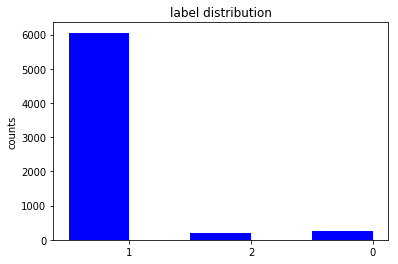

In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
responses = df2.groupBy ('quality'). count (). collect () 
categories = [i [0] for i in responses] 
counts = [i [1] for i in responses] 
ind = np.array (range ( len (categories))) 
width = 0.5 
plt.bar (ind, counts, width = width, color = 'b') 
plt.ylabel ('counts') 
plt.title ('label distribution') 
plt.xticks (ind + width / 2., categories) 
plt.show ()

In [66]:
low.count()

246

In [67]:
medium.count()

6053

In [68]:
high.count()

198

In [11]:
sampleRatio = float (low.count ()) / float (df2.count ())
medium_filtered = medium.sample (False, sampleRatio)


In [12]:
medium_filtered.count()

229

In [13]:
df2 = medium_filtered.unionAll (high).unionAll(low)

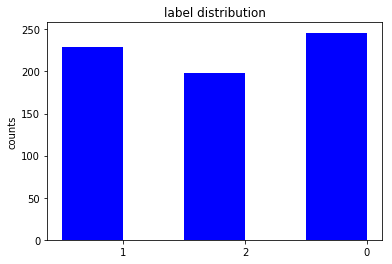

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
responses = df2.groupBy ('quality'). count (). collect () 
categories = [i [0] for i in responses] 
counts = [i [1] for i in responses] 
ind = np.array (range ( len (categories))) 
width = 0.5 
plt.bar (ind, counts, width = width, color = 'b') 
plt.ylabel ('counts') 
plt.title ('label distribution') 
plt.xticks (ind + width / 2., categories) 
plt.show ()

In [15]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)

In [16]:
allData = pipeline.fit(df2).transform(df2)
allData.cache()
trainingData, testData = allData.randomSplit([0.7,0.3], seed=0)


In [76]:
pd.DataFrame(trainingData.take(3),columns = trainingData.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides,features
0,0,8.0,120.0,0.99767,9.6,1,0.53,0.25,15.0,0.20,3.19,6.2,0.055,"[6.2, 0.2, 0.25, 15.0, 0.055, 8.0, 120.0, 0.99..."
1,0,10.0,51.0,0.98878,12.6,1,0.58,0.32,2.5,0.15,3.04,5.4,0.037,"[5.4, 0.15, 0.32, 2.5, 0.037, 10.0, 51.0, 0.98..."
2,0,12.0,120.0,0.98940,14.0,1,0.79,0.21,2.6,0.29,3.39,5.8,0.025,"[5.8, 0.29, 0.21, 2.6, 0.025, 12.0, 120.0, 0.9..."


In [45]:
trainingData = trainingData.withColumnRenamed('quality','label')
testData = testData.withColumnRenamed('quality','label')

#RandomForest
from pyspark.ml.classification import RandomForestClassifier as RF
rf = RF(labelCol='label', featuresCol='features',numTrees=200)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(transformed)
print("Accuracy = " + str(rf_accuracy))
print("Error = %g " % (1.0 - rf_accuracy))

Accuracy = 0.6476683937823834
Error = 0.352332 


In [46]:
pd.DataFrame(transformed.take(2),columns = transformed.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,label,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides,features,rawPrediction,probability,prediction
0,0,4.0,117.0,0.99032,12.2,1,0.44,0.34,1.9,0.235,3.40,6.2,0.036,"[6.2, 0.235, 0.34, 1.9, 0.036, 4.0, 117.0, 0.9...","[103.61044989400482, 25.367404048602143, 71.02...","[0.518052249470024, 0.12683702024301072, 0.355...",0.0
1,0,8.0,97.0,0.99270,11.0,1,0.41,0.30,5.7,0.350,3.27,6.3,0.035,"[6.3, 0.35, 0.3, 5.7, 0.035, 8.0, 97.0, 0.9927...","[125.14662772992943, 36.89475718599793, 37.958...","[0.6257331386496473, 0.18447378592998973, 0.18...",0.0


predict_labels = transformed.select("prediction","label")
pred_label_rdd = predict_labels.rdd
multi_metrics = MulticlassMetrics(pred_label_rdd)
print("Precision: %.3f" % (multi_metrics.precision() * 100))
print("Recall: %.3f" % (multi_metrics.recall() * 100))
f1measure = multi_metrics.fMeasure()
print("F1 Score: %.3f"%(f1measure*100))

In [48]:
from pyspark.sql.types import DoubleType
transformed_after = transformed.withColumn('label', transformed['label'].cast('double'))

In [49]:
transformed_after.printSchema()

root
 |-- type: integer (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- label: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- fixed acidity: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [51]:
predict_labels = transformed_after.select("prediction","label")
pred_label_rdd = predict_labels.rdd
rf_metrics = MulticlassMetrics(pred_label_rdd)
rf_precision = rf_metrics.precision()
rf_recall = rf_metrics.recall()
rf_f1Score = rf_metrics.fMeasure()

print("Summary Stats Random Forest")
print("Accuracy = %s" % rf_accuracy)
print("Precision = %s" % rf_precision)
print("Recall = %s" % rf_recall)
print("F1 Score = %s" % rf_f1Score)

Summary Stats Random Forest
Accuracy = 0.6476683937823834
Precision = 0.6476683937823834
Recall = 0.6476683937823834
F1 Score = 0.6476683937823834


In [68]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
trainingData_con = trainingData.withColumn('label', trainingData['label'].cast('double'))
testData_con = testData.withColumn('label', testData['label'].cast('double'))
# Train model with Training Data
lrModel = lr.fit(trainingData_con)
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData_con)


In [66]:
#predictions_after = predictions.withColumn('label', predictions['label'].cast('double'))

In [69]:
predict_labels = predictions_after.select("prediction","label")
pred_label_rdd = predict_labels.rdd
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(pred_label_rdd)
#print("Area under Precision/Recall (PR) curve: %.3f" % (metrics.areaUnderPR * 100))
multi_metrics = MulticlassMetrics(pred_label_rdd)
print("Precision: %.3f" % (multi_metrics.precision() * 100))
print("Recall: %.3f" % (multi_metrics.recall() * 100))
f1measure = multi_metrics.fMeasure()
print("F1 Score: %.3f"%(f1measure*100))

Precision: 39.378
Recall: 39.378
F1 Score: 39.378
